# 3D Occupancy Grid with ibeo Lux Laser Scanner

![ibeo Lux](http://www.mechlab.de/wp-content/uploads/2012/02/ibeoLUX.jpg)

In this assignment, you will have three tasks to generate a probabilistic occupancy grid from Lidar scanning data.

1) Write code to convert data in spherical coordinates to Cartesian coordinates in the function `ibeo2XYZ()`.

2) Perform the logodds update for the `grid` global variable in `insertPointcloudBRESENHAM()`.

3) Convert the logodds grid to a probablistic occupancy grid.

These tasks are marked with TODOs. Additional supplemental information is given throughout the notebook. 

With your submitted notebook, please also include written answers to the following questions:

1) What are the computational advantages of using logodds when generating our occupancy grid?

Ans: It allows us to represent probabilities using log-odd values which are in the range of [-inf, inf] and can be clamped to finite values. It is numerically stable as the logits exist within a finite bound and do not approach zero, this is advantageous as we are not dealing with very small numbers that can lead to underflows and overflows which is difficult for computers to deal with. In addition it is computationally efficient as allows for updates to be done using addition and subtraction instead of multiplication and division.

2) Is the angle phi in our Spherical to Cartesian calculation the same as the polar angle in standard Spherical coordinates? Why?

Ans: No it is not the same in Spherical coordinates the polar angle is the angle between the ray and the Z axis while what we have for phi is the angle between the ground plane and the ray which is the complement of the polar angle

In [134]:
import numpy as np
import time
import pandas as pd
import math

In [135]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interact
import ipywidgets
%matplotlib inline

### Create Empty Grid

In [136]:
l = 10.0 # Length (m)
b = 10.0  # Width (m)
h = 2.0  # Height (m)

r = 0.1 # Resolution (m/gridcell)

## Generate a LogOdds Grid

Why LogOdds? It is numerically stable around $p=0$ and $p=1$, and it reduces the computation to update the Grid (Bayes Rule) to just an addition.


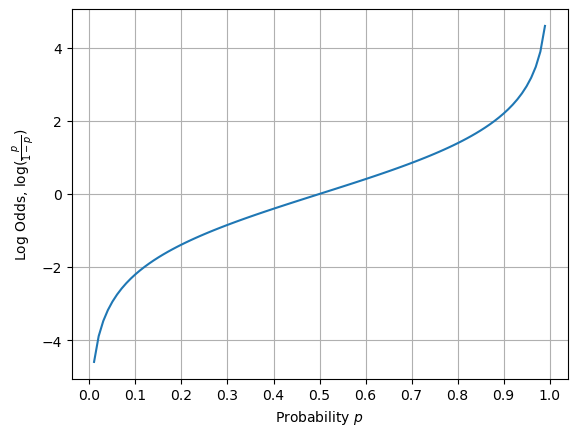

In [137]:
p = np.arange(0.01, 1.0, 0.01)
lo = np.log(p/(1-p))
plt.plot(p, lo)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Probability $p$')
plt.ylabel(r'Log Odds, $\log(\frac{p}{1-p})$')
plt.grid(True)

So, an initial uncertainty ($p=0.5$) is a zero in LogOdds. That's fine, because it is a very fast initialization of the grid!
In order to store log(odds), we need negative values and decimal values.


In [138]:
print("{}x{}x{} Grid".format(int(round(l/r)), int(round(b/r)), int(round(h/r))))
startTime = time.time()

grid = np.zeros((int(round(l/r)), int(round(b/r)), int(round(h/r))), dtype=np.float32) # Log Odds Grid must be initialized with zeros!

print("Stats: {:.2f}s, {:.2f}GB".format(time.time() - startTime, (grid.nbytes/1024.0**2)))

100x100x20 Grid
Stats: 0.00s, 0.76GB


### 3D View
This helper function will be useful for our 3D plots later.

In [139]:
def plot3Dgrid(grid, az, el):
    # Plot the surface.
    #_, plt3d = plt.figure(figsize=(12, 6)).gca(projection='3d', facecolor='w')
    _, plt3d = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': '3d'})

    # Create x,y mesh.
    ll, bb = np.meshgrid(range(grid.shape[1]), range(grid.shape[0]))

    for z in range(grid.shape[2]):
        if not (np.max(grid[:,:,z])==np.min(grid[:,:,z])): # don't show the untouched level
            cp = plt3d.contourf(ll, bb, grid[:,:,z], offset = z, alpha=0.3, cmap=cm.Greens)

    cbar = plt.colorbar(cp, shrink=0.7, aspect=20)
    cbar.ax.set_ylabel('$P(m|z,x)$')
    
    plt3d.set_xlabel('X')
    plt3d.set_ylabel('Y')
    plt3d.set_zlabel('Z')
    plt3d.set_xlim3d(0, grid.shape[0])
    plt3d.set_ylim3d(0, grid.shape[1])
    plt3d.set_zlim3d(0, grid.shape[2])
    plt3d.view_init(az, el)
    return plt3d

## Integrate a measurement with BRESENHAM Algorithm

Amanatides, J., & Woo, A. (1987). A fast voxel traversal algorithm for ray tracing. Proceedings of EUROGRAPHICS, i. Retrieved from http://www.cse.yorku.ca/~amana/research/grid.pdf

Here is a Python Implementation of BRESENHAM Algorithm: https://gist.github.com/salmonmoose/2760072

In [140]:
def bresenham3D(startPoint, endPoint):
   # by Anton Fletcher
   # Thank you!
   path = [] 
    
   startPoint = [int(startPoint[0]),int(startPoint[1]),int(startPoint[2])]
   endPoint = [int(endPoint[0]),int(endPoint[1]),int(endPoint[2])]
 
   steepXY = (np.abs(endPoint[1] - startPoint[1]) > np.abs(endPoint[0] - startPoint[0]))
   if(steepXY):   
      startPoint[0], startPoint[1] = startPoint[1], startPoint[0]
      endPoint[0], endPoint[1] = endPoint[1], endPoint[0]
 
   steepXZ = (np.abs(endPoint[2] - startPoint[2]) > np.abs(endPoint[0] - startPoint[0]))
   if(steepXZ):
      startPoint[0], startPoint[2] = startPoint[2], startPoint[0]
      endPoint[0], endPoint[2] = endPoint[2], endPoint[0]
 
   delta = [np.abs(endPoint[0] - startPoint[0]), np.abs(endPoint[1] - startPoint[1]), np.abs(endPoint[2] - startPoint[2])]

   errorXY = delta[0] / 2
   errorXZ = delta[0] / 2
 
   step = [
      -1 if startPoint[0] > endPoint[0] else 1,
      -1 if startPoint[1] > endPoint[1] else 1,
      -1 if startPoint[2] > endPoint[2] else 1
   ]
 
   y = startPoint[1]
   z = startPoint[2]
 
   for x in range(startPoint[0], endPoint[0], step[0]):
      point = [x, y, z]
 
      if(steepXZ):
          point[0], point[2] = point[2], point[0]
      if(steepXY):
          point[0], point[1] = point[1], point[0]

 
      errorXY -= delta[1]
      errorXZ -= delta[2]
 
      if(errorXY < 0):
          y += step[1]
          errorXY += delta[0]
 
      if(errorXZ < 0):
          z += step[2]
          errorXZ += delta[0]

      path.append(point)

   return path

In [141]:
import string
letters = string.ascii_lowercase

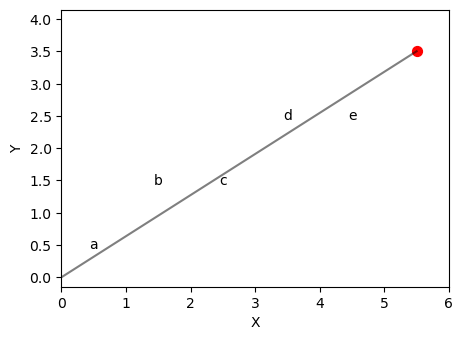

In [142]:
goal = (5.5, 3.5, 0.0)

plt.figure(figsize=(5.0,3.6))
plt.scatter(goal[0], goal[1], s=50, c='r')
plt.plot((0, goal[0]), (0, goal[1]), c='k', alpha=0.5)
plt.axis('equal');
plt.xlim(0, 6)
plt.ylim(0, 4)
plt.xlabel('X')
plt.ylabel('Y')

# Annotations
cells = bresenham3D((0,0,0), (goal[0], goal[1], 0.0))

for i, cell in enumerate(cells):
    plt.text(cell[0]+0.5, cell[1]+0.5, letters[i], ha='center', va='center')

plt.savefig('BRESENHAM-Raycasting.png', dpi=150)

Does not hit all traversed grid cells

### Sensor Position and Orientation

For rotation and translation in homogeneous coordinates, everything can be done via Matrix multiplication.

$$\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right]_\text{Endpoint} = \left[\begin{matrix} R_{3x3} & t_{3x1} \\ 0 & 1\end{matrix}\right] \cdot \left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right]_\text{Measurement}$$

where $R$ is the rotation matrix and $t$ is the displacement vector.

In [143]:
def Rypr(y, p, r):
    '''
    Rotation matrix for y=yaw, p=pitch, r=roll, in degrees
    '''
    # from Degree to Radians
    y = y*np.pi/180.0
    p = p*np.pi/180.0
    r = r*np.pi/180.0
    
    Rr = np.matrix([[1.0, 0.0, 0.0],[0.0, np.cos(r), -np.sin(r)],[0.0, np.sin(r), np.cos(r)]])
    Rp = np.matrix([[np.cos(p), 0.0, np.sin(p)],[0.0, 1.0, 0.0],[-np.sin(p), 0.0, np.cos(p)]])
    Ry = np.matrix([[np.cos(y), -np.sin(y), 0.0],[np.sin(y), np.cos(y), 0.0],[0.0, 0.0, 1.0]])
    
    return Ry*Rp*Rr

In [144]:
def ibeo2XYZ(theta, dist, layer, R, t):
    '''
    Computes the Cartesian x, y, and z coordinates from the polar coordinates of the IBEO Lux laser scanner.
   
    Input:
        - theta: horizontal angle
        - dist : polar distance
        - layer: level
        - R    : Euler rotation matrix (rotation of laser scanner)
        - t    : displacement vector (position of Laserscanner)
    '''
    if not R.shape == (3,3):
        raise ValueError('Rotation matrix must be 3x3.')
    if not t.shape == (3,1):
        raise ValueError('Displacement vector must be 3x1: [X],[Y],[Z].')
    
    
    # Ibeo Lux has a 3.2° aperture angle and 4 vertical levels.
    aperture_angle = 3.2
    levels = 4
    
    # Calculate the angle of incidence of the current layer's point to the ground plane.
    # Input layer varies from 0 to 3, and the aperture layers are centered at the horizontal.
    phi = (layer * aperture_angle/(levels-1) - aperture_angle/2.0) * np.pi/180.0
    
    # TODO ###################################################################################
    # Compute the cartesian coordinates from the radius dist, horizontal angle theta, and the
    # vertical angle phi. Note that phi is the angle from the ground plane to the ray, not from
    # the ray to the vertical axis!

    # phi is the complement of the polar angle

    # Recall conversion equations of cartesian to spherical
    # x, y
    # theta = arctan(y/x)
    # r = sqrt(x^2+y^2)
    # x= dist*sin(horizontal_angle)*cos(vertical_angle)
    # phi = np.pi/2 - phi
    horizontal_angle = theta
    vertical_angle = np.pi/2 - phi
    X = dist*np.cos(horizontal_angle)*np.sin(vertical_angle)
    # Y = r*sin(theta)*sin(phi)
    Y = dist*np.sin(horizontal_angle)*np.sin(vertical_angle)
    # Z = r*cos(theta)
    Z = dist*np.cos(vertical_angle)

    # Start with the identity matrix.
    RSensor = np.eye(4)

    # Rotation portion.
    RSensor[np.ix_([0,1,2],[0,1,2])] = R

    # Translation portion.
    RSensor[np.ix_([0,1,2],[3])] = t
    
    Pointcloud = np.array((X,Y,Z,np.ones(np.size(X))))

    # Homogeneous multiplication of points for rotation + translation.
    [xe,ye,ze,w] = np.dot(RSensor, Pointcloud)
    
    return np.array([xe, ye, ze])

### Load some Ibeo Lux Measurements

In [145]:
# Load Real World Ibeo Lux Measurements.
data = pd.read_csv('Measurements.txt', delimiter='|')

In [146]:
data.head(5)

,# <Timestamp>,<Level>,<Echo>,<Angle>,<Radius>,<Xvalue>,<Yvalue>,<EchoPulseWidth>,<Scanflags>
0,1341907053031,0,0,0.872665,1024,658,784,108,4
1,1341907053031,0,0,0.855211,999,655,753,172,4
2,1341907053031,1,0,0.855211,872,572,658,108,3
3,1341907053031,1,1,0.855211,1061,696,800,176,4
4,1341907053031,0,0,0.846485,979,648,733,148,20


#### Filter out an arbitrary measurement and bounded angle

In [147]:
timestamp = 1341907053031
f = (data['# <Timestamp>']==timestamp) & (data['<Angle>']<0.5) & (data['<Angle>']>-0.5)

angles = data['<Angle>'][f]
distance = data['<Radius>'][f]/100.0
layer = data['<Level>'][f]

In [148]:
yaw   = 0.0 #  Yaw in Degrees
pitch = 0.0 #  Pitch in Degrees
roll  = 0.0 #  Roll in Degrees
dx= 0.0 #  Delta X (m)
dy= 5.0 #  Delta Y (m)
dz= 1.0 #  Delta Z (m)

In [149]:
# Convert from spherical coordinates to Cartesian.
R = Rypr(yaw, pitch, roll)
t = np.array([[dx], [dy], [dz]]) 
[xe, ye, ze] = ibeo2XYZ(angles.values, distance.values, layer.values, R, t)

Text(0.5, 0.5, 'Y')

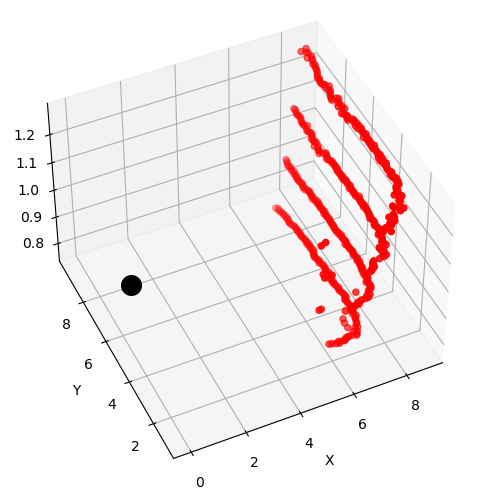

In [150]:
# Plot the location of the scanner (black), and the pointcloud (red).
_, plt3d = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': '3d'})
#plt3d = plt.figure(figsize=(12, 6)).gca(projection='3d', facecolor='w')
# plt3d = plt.figure(figsize=(12, 6)).gca(projection='3d')
plt3d.scatter(xe, ye, ze, c='r', label='Laserscanner Pointcloud')
plt3d.scatter(t[0], t[1], t[2], c='k', s=200, label='ibeo Lux')
plt3d.view_init(45, -115)
plt3d.axis()
plt3d.set_xlabel('X')
plt3d.set_ylabel('Y')

## Function which integrates the Measurement via Inverse Sensor Model

Values for hit and miss probabilities are taken from Hornung, A., Wurm, K. M., Bennewitz, M., Stachniss, C., & Burgard, W. (2013). OctoMap: an efficient probabilistic 3D mapping framework based on octrees. Autonomous Robots, 34(3), 189–206. doi:10.1007/s10514-012-9321-0

In [151]:
# in LogOdds Notation!
loccupied = 0.85
lfree = -0.4

lmin = -2.0
lmax = 3.5

In [152]:
def insertPointcloudBRESENHAM(tSensor, xe,ye,ze):    
    for i,val in enumerate(xe):        
        # Insert Endpoints.
        y=int(xe[i])
        x=int(ye[i]) # Coordinate switch between X & Y!
        z=int(ze[i])

        # Inverse Sensor Model.
        # TODO ###############################################################################
        # This point is occupied by an object. Increment its logodds in the grid by loccupied.
        # Be sure to clamp to the maximum logodds value, lmax.
        #grid[x,y,z] = ...

        # if logodds greater than max, clamp to max 
        # otherwise update 
        if grid[x,y,z] +  loccupied > lmax:
            grid[x,y,z] = lmax
        else:
            grid[x,y,z] += loccupied 


        # TODO ###############################################################################
        # These grid cells are along the ray of the scanner. Because of this, they are unlikely to 
        # be occupied. Reduce their logodds using lfree.
        for (y,x,z) in bresenham3D(tSensor, (xe[i], ye[i], ze[i])): # Coordinate switch between X & Y!
            #grid[x,y,z] = ...
            # if logodds greater than min, clamp to min 
            # otherwise update 
            if grid[x,y,z] +  lfree < lmin:
                grid[x,y,z] = lmin
            else:
                grid[x,y,z] += lfree


### Sensor Origin

In [153]:
tSensor = t/r  # Translation (shift from 0,0,0) in Grid Cell Numbers
tSensor

array([[ 0.],
       [50.],
       [10.]])

In [154]:
# integrate the measurement 5 times
for m in range(5):
    try:
        insertPointcloudBRESENHAM(tSensor, xe/r,ye/r,ze/r)
    except:
        print('Error while inserting the measurement. Is the grid too small?')

### 2D Plot of Grid Layer Z
Here we plot the projection of the laser scan in the 2D plane. The z slider controls which constant z plane we project into.

In [155]:
@interact
def plotmultivargauss(z = ipywidgets.IntSlider(min=0, max=np.max(grid.shape[2])-1, step=1, value=10, description="")):
    plt.figure(figsize=(int(round(l/2)), int(round(b/2))))
    plt.contourf(grid[:,:,z], cmap=cm.Greens)
    plt.axis('equal')
    plt.xlabel('X')
    plt.ylabel('Y')

interactive(children=(IntSlider(value=10, description='z', max=19), Output()), _dom_classes=('widget-interact'…

### 3D Plot
Here we perform the full 3D plot.

In [156]:
@interact
def plotmultivargauss(az = ipywidgets.IntSlider(min=-90.0, max=90.0, step=1.0, value=45.0, description=""), \
                      el = ipywidgets.IntSlider(min=-180.0, max=180.0, step=1.0, value=-115.0, description="")):

    plot3Dgrid(grid, az, el)

interactive(children=(IntSlider(value=45, description='az', max=90, min=-90), IntSlider(value=-115, descriptio…

In [157]:
print('Max Grid Value (Log Odds): %.2f' % np.max(grid))
print('Min Grid Value (Log Odds): %.2f' % np.min(grid))

Max Grid Value (Log Odds): 3.50
Min Grid Value (Log Odds): -2.00


## From LogOdds Occupancy Grid to Probability Grid

The conversion from LogOdds notation to probabilities could be achieved by following formula:

$$P(l) = 1-\cfrac{1}{1+e^{lo}}$$ with $lo$=LogOdds Value

In [158]:
# TODO ####################################################################
# Convert the logodds grid to a probabilisitic occupancy grid, using the formula above.
gridP = 1 - 1/(1+ np.exp(grid))
# print(gridP)

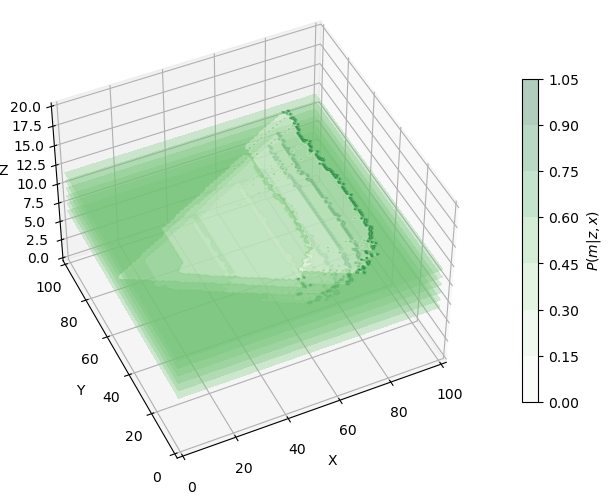

In [159]:
plot3Dgrid(gridP, 45, -115)
plt.savefig('3D-Occupancy-Grid.png')

In [160]:
print('Max Grid Value (Probability): %.2f' % np.max(gridP))
print('Min Grid Value (Probability): %.2f' % np.min(gridP))

Max Grid Value (Probability): 0.97
Min Grid Value (Probability): 0.12


## Convolve the Map for Path Planning
We convolve our 3D map with a Gaussian filter to output a smooth occupancy grid for motion planning.

In [161]:
from scipy.ndimage import gaussian_filter

In [162]:
blurmap = gaussian_filter(gridP, 0.4)

<Axes3DSubplot: xlabel='X', ylabel='Y', zlabel='Z'>

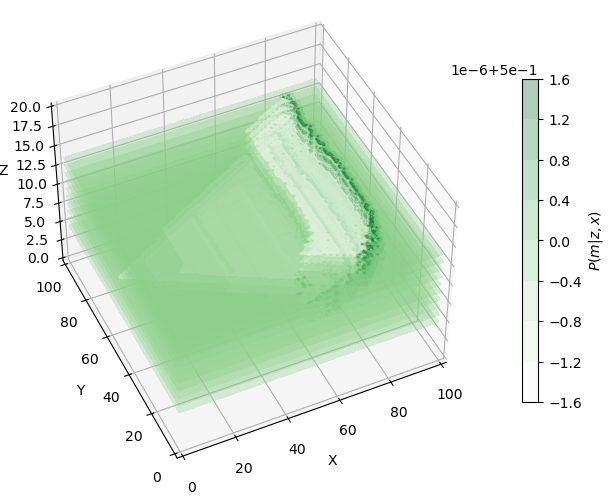

In [163]:
plot3Dgrid(blurmap, 45, -115)

In [164]:
print('Max Grid Value (Probability): %.2f' % np.max(blurmap))
print('Min Grid Value (Probability): %.2f' % np.min(blurmap))

Max Grid Value (Probability): 0.91
Min Grid Value (Probability): 0.12
